# import library and dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('News.csv')

In [3]:
df.head()

,Unnamed: 0,title,text,subject,date,class
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [4]:
df.shape

(44919, 6)

In [5]:
df = df.drop(['subject','title','date','Unnamed: 0'],axis=1)

In [6]:
df

,text,class
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
44914,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44915,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44916,MINSK (Reuters) - In the shadow of disused Sov...,1
44917,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [7]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [8]:
# Shuffling
df = df.sample(frac = 1)
df.reset_index(inplace = True)
df.drop(['index'],axis=1,inplace=True)

<Axes: xlabel='class', ylabel='count'>

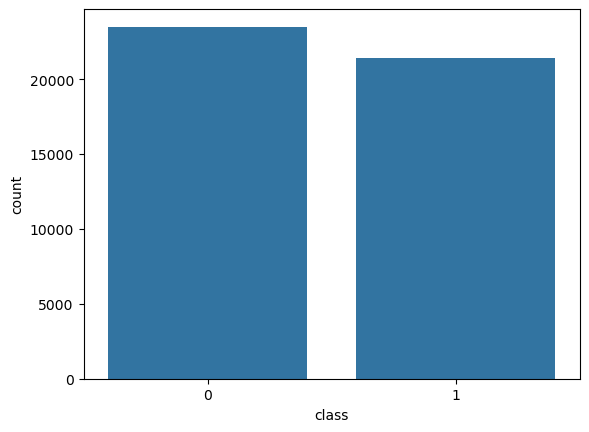

In [9]:
# Countplot
sns.countplot(data = df,
              x = 'class',
              order = df['class'].value_counts().index)

In [10]:
from tqdm import tqdm
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dheer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dheer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
def preprocess_text(text_data):
  preprocessed_text = []
  stemmer = PorterStemmer()
  for sentence in tqdm(text_data):
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuation and numbers
    sentence = sentence.lower() # Convert to lowercase
    words = sentence.split() # Tokenize
    words = [stemmer.stem(word) for word in words if word not in stopwords.words('english')] # Remove stopwords and stem
    preprocessed_text.append(' '.join(words))
  return preprocessed_text

In [12]:
preprocessed_review = preprocess_text(df['text'].values)
df['text'] = preprocessed_review

100%|██████████████████████████████████████████████████████████████████████████| 44919/44919 [2:19:47<00:00,  5.36it/s]


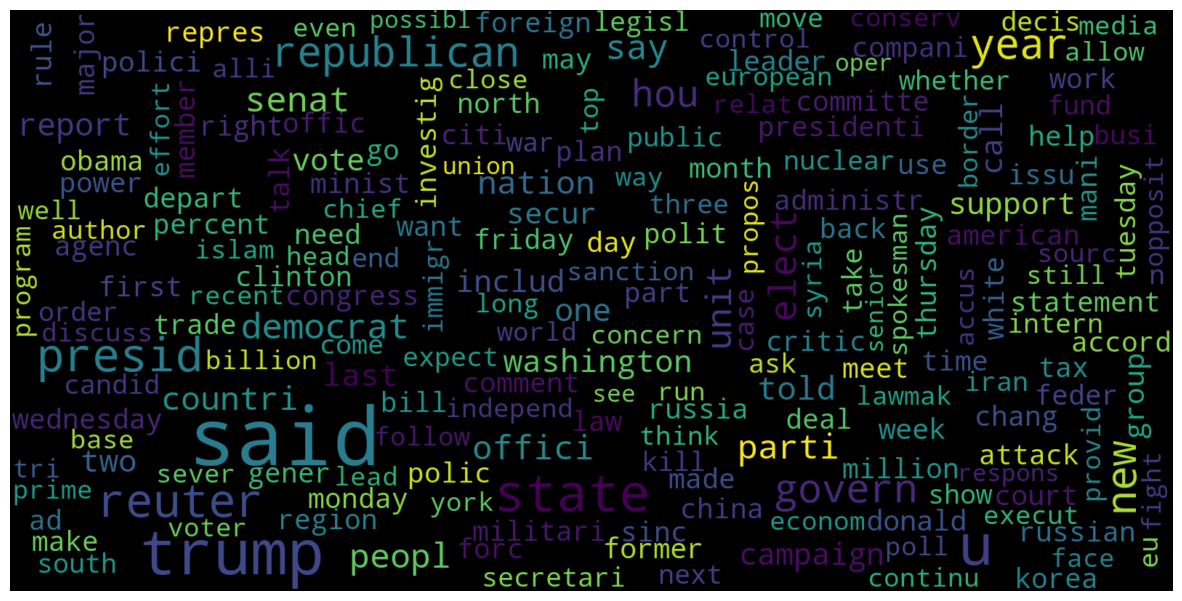

In [13]:
# Real News
consolidated = ' '.join(
    word for word in df['text'][df['class'] == 1].astype(str))
wordcloud = WordCloud(
    width = 1600,
    height = 800,
    random_state = 21,
    max_font_size = 110,
    collocations = False
)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

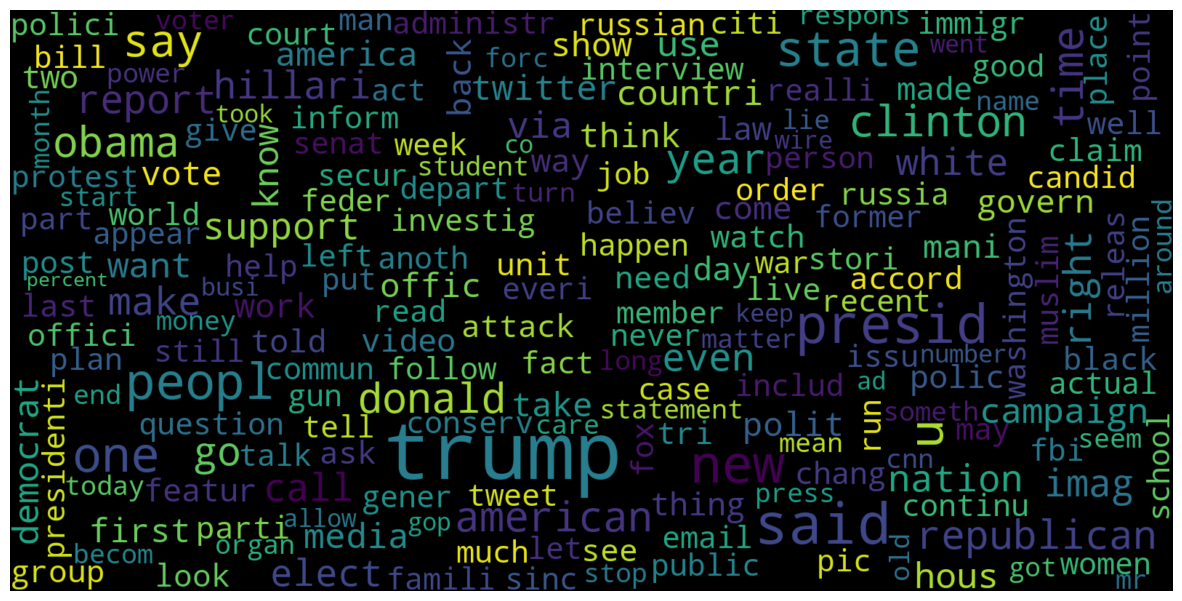

In [14]:
# Fake News
consolidated = ' '.join(
    word for word in df['text'][df['class'] == 0].astype(str))
wordcloud = WordCloud(
    width = 1600,
    height = 800,
    random_state = 21,
    max_font_size = 110,
    collocations = False
)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

# Bar Chart

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

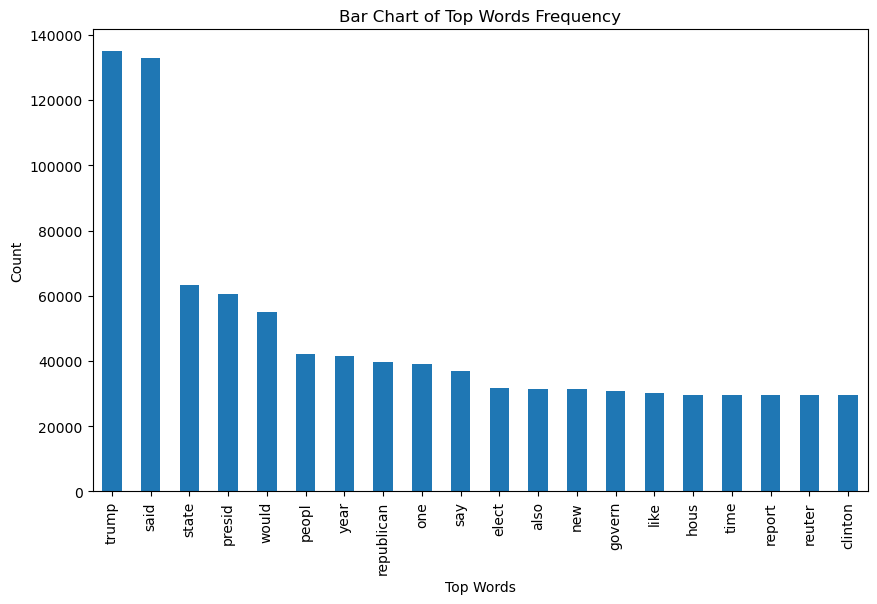

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None) :
  vec = CountVectorizer().fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx])
  for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1],
                      reverse = True)
  return  words_freq[:n]


common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

# Model trainig(train test split)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

X_train,X_test,y_train,y_test = train_test_split(df['text'],df['class'],test_size=0.25)

# Support Vector Machine

In [17]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Re-vectorize X_train and X_test before training the model
vectorization = TfidfVectorizer()
X_train_vec = vectorization.fit_transform(X_train)
X_test_vec = vectorization.transform(X_test)


model = SVC(kernel = 'linear')
model.fit(X_train_vec,y_train)
y_pred = model.predict(X_train_vec)
y_pred1 = model.predict(X_test_vec)

# Testing the model

In [18]:
print(accuracy_score(y_train,y_pred))
print(accuracy_score(y_test,y_pred1))

0.9978331206031642
0.9943009795191452


# Confusion Matrix

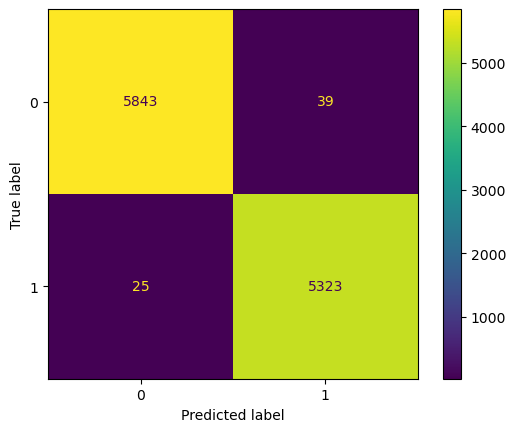

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5882
           1       0.99      1.00      0.99      5348

    accuracy                           0.99     11230
   macro avg       0.99      0.99      0.99     11230
weighted avg       0.99      0.99      0.99     11230



# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(X_train_vec,y_train)
y_pred = model1.predict(X_train_vec)
y_pred1 = model1.predict(X_test_vec)

# Testing the model

In [22]:
print(accuracy_score(y_train,y_pred))
print(accuracy_score(y_test,y_pred1))

0.9898483184422215
0.9861976847729297


# Confusion Matrix

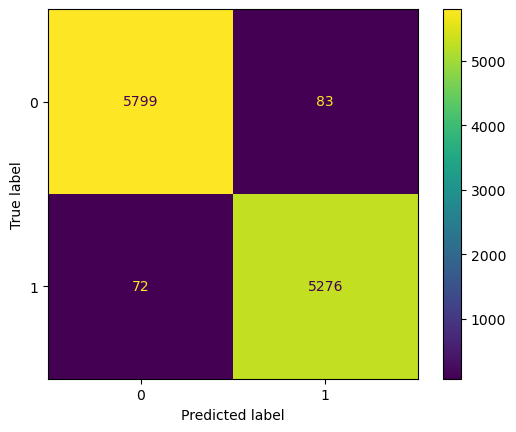

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test,y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()